In [1]:
from functools import partial
from dataclasses import dataclass
from typing import Any, Callable
from __future__ import annotations
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils.extmath import cartesian
from sklearn.calibration import calibration_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import classification_report

In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

## 線形回帰モデルは何を推定しているのか
$$
\renewcommand{\paren}[1]{\left(#1\right)}
\renewcommand{\brac}[1]{\left[#1\right]}
\renewcommand{\P}[1]{\Pr\paren{#1}}
\renewcommand{\E}[1]{\mathbb{E}\brac{#1}}
\renewcommand{\var}[1]{\mathbb{V}\brac{#1}}
\renewcommand{\ate}[]{\mathrm{ATE}}
\renewcommand{\att}[]{\mathrm{ATT}}
\renewcommand{\atu}[]{\mathrm{ATU}}
$$

因果推論の文脈で処置効果（treatment effect）を推定する様々な手法が提案されていますが、実務家の中ではまだまだOLSで処置効果を分析している例が多く見られます。
処置効果をOLSで推定する典型的な例として、以下のような線形回帰モデル
$$
\begin{align}
    Y = \alpha + \tau D + X^\top\beta + U
\end{align}
$$
を考えます。
ここで、それぞれ
- $Y$：目的変数
- $D$：処置を受けたら1、受けていなければ0をとるダミー変数
- $X$：コントロール変数
- $U$：誤差項
- $\tau$：OLSで推定される処置効果
- $(\alpha, \beta)$：その他の回帰パラメータ
を表しています。

平たく言うと、「処置変数$D$とコントロール変数$X$をぜんぶ回帰モデルに突っ込んで、処置変数$D$の回帰係数$\tau$を推定したら、これが処置の平均的な効果でしょ」というのがこのモデルの発想です。
実際、処置効果が一定なら、OLSで推定した処置効果は（いくつかの仮定のもとで）真の処置効果と一致します。
問題は処置効果に異質性がある場合です。

処置効果に異質性がある場合、代表的な推定したい効果（estimand）として
- ATE：サンプル全体に対する平均的な処置効果
- ATT：処置群に対する平均的な処置効果
- ATU：対照群に対する平均的な処置効果
が挙げられますが、（処置効果の異質性を明示的に考慮せずに）OLSで処置効果$\tau$を推定した場合、一体どのグループに対する平均的な処置効果が推定されるのでしょうか？
この疑問に対して、OLSで推定された処置効果は（いくつかの仮定のもとで）以下のようなATTとATUの加重平均になるというのが論文の主張です。
$$
\begin{align}
\tau = w\tau_{\att} + (1-w)\tau_{\atu}
\end{align}
$$
ここで、重み$w$は
$$
\begin{align}
w &= \frac{\paren{1 - \rho}\var{e(X) \mid D=0}}{\rho\var{e(X) \mid D=1} + \paren{1 - \rho}\var{e(X) \mid D=0}}
\end{align}
$$
で定義され、$\rho = \P{D=1}$はサンプルに占める処置群の割合を、さらに$e(X)$は傾向スコアを表します。

話を簡単にするために、いったん傾向スコアの条件付き分散は一定（$\var{e(X) \mid D=0} = \var{e(X) \mid D=1} = \sigma^2$）としましょう。
すると、重み$w$は
$$
\begin{align}
w 
&= \frac{\paren{1 - \rho}\sigma^2}{\rho\sigma^2 + \paren{1 - \rho}\sigma^2}\\
&= 1 - \rho
\end{align}
$$
と簡略化できます。
よって、OLSで推定した処置効果は、
$$
\begin{align}
\tau = \paren{1-\rho}\tau_{\att} + \rho\tau_{\atu}
\end{align}
$$
と書けます。
つまり、サンプルに占める処置群の割合が大きくなるほどATUに近くなり、対照群の割合が大きくなるほどATTに近くなることがわかります。

OLSで推定した処置効果はATTとATUの加重平均なのでATEになっているかというと、そうでもありません。
ATEはサンプル全体の処置効果なので、ATTは処置群の割合で、ATUは対照群の割合で重みを付けて加重平均します。
$$
\tau_{\ate} = \rho \tau_{\att} + \paren{1-\rho}\tau_{\atu}
$$
つまり、OLSによって推定される処置効果とATEは逆の割合でATTとATUの重みを付けた加重平均になっています。

## シミュレーション

$$
\begin{align}
    Y &= \tau(X) D + X + U,\\
    X &\sim \mathrm{Uniform}(0, 1),\\
    D &\sim \mathrm{Bernoulli}(e(X)),\\
    U &\sim \mathcal{N}(0, 0.1^2),\\
    \tau(X) &= X,\\
    e(X) &= \P{D = 1 \mid X} = \theta X\\
\end{align}
$$

In [149]:
def generate_simulation_data(
    n_samples: int, theta: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X = np.random.uniform(0, 1, n_samples)
    U = np.random.normal(0, 0.1, n_samples)

    e_X = theta * X
    D = np.random.binomial(1, e_X, n_samples)
    tau = X

    Y = tau * D + X + U

    return (X, Y, D, tau, e_X)


def estimate_tau(X: np.ndarray, D: np.ndarray, Y: np.ndarray) -> float:
    """"""
    Z = np.column_stack([X, D])
    return (np.linalg.inv(Z.T @ Z) @ (Z.T @ Y))[1]



def calc_treatment_effect(
    D: np.ndarray, tau: np.ndarray, e_X: np.ndarray
) -> tuple[float, float, float, float, float]:
    """"""
    is_treat = D.astype(bool)

    att = tau[is_treat].mean()
    atu = tau[~is_treat].mean()
    ate = tau.mean()
    
    rho = D.mean()
    var_e_0 = tau[~is_treat].var()
    var_e_1 = tau[is_treat].var()
    w = (1 - rho) * var_e_0 / ((1 - rho) * var_e_0 + rho * var_e_1)
    
    return (att, atu, ate, rho, w)


thetas = np.arange(0.1, 1.1, 0.1)
results = np.zeros((thetas.shape[0], 6))
for t, theta in enumerate(thetas):
    X, Y, D, tau, e_X = generate_simulation_data(n_samples=1000000, theta=theta)
    tau_hat = estimate_tau(X, D, Y)
    att, atu, ate, rho, w = calc_treatment_effect(D, tau, e_X)
    results[t, :] = np.array([rho, w, tau_hat, att, atu, ate])

In [160]:
df_simulation = pd.DataFrame({"theta": thetas})
df_simulation[["rho", "w", "OLS", "ATT", "ATU", "ATE"]] = results

df_simulation

,theta,rho,w,OLS,ATT,ATU,ATE
0,0.1,0.049936,0.966134,0.660386,0.666320,0.491102,0.499851
1,0.2,0.100261,0.930346,0.653206,0.666083,0.481873,0.500342
2,0.3,0.149436,0.893955,0.646007,0.666996,0.470537,0.499895
3,0.4,0.200322,0.853936,0.636099,0.666459,0.458448,0.500117
4,0.5,0.250460,0.812285,0.624838,0.666954,0.445526,0.500985
5,0.6,0.299184,0.767195,0.611162,0.666913,0.428124,0.499566
6,0.7,0.350176,0.715527,0.593569,0.666590,0.410444,0.500140
7,0.8,0.399849,0.657193,0.572094,0.666760,0.388844,0.499968
8,0.9,0.449752,0.587906,0.541884,0.666344,0.363639,0.499781
9,1.0,0.499986,0.499756,0.500264,0.666827,0.333450,0.500134


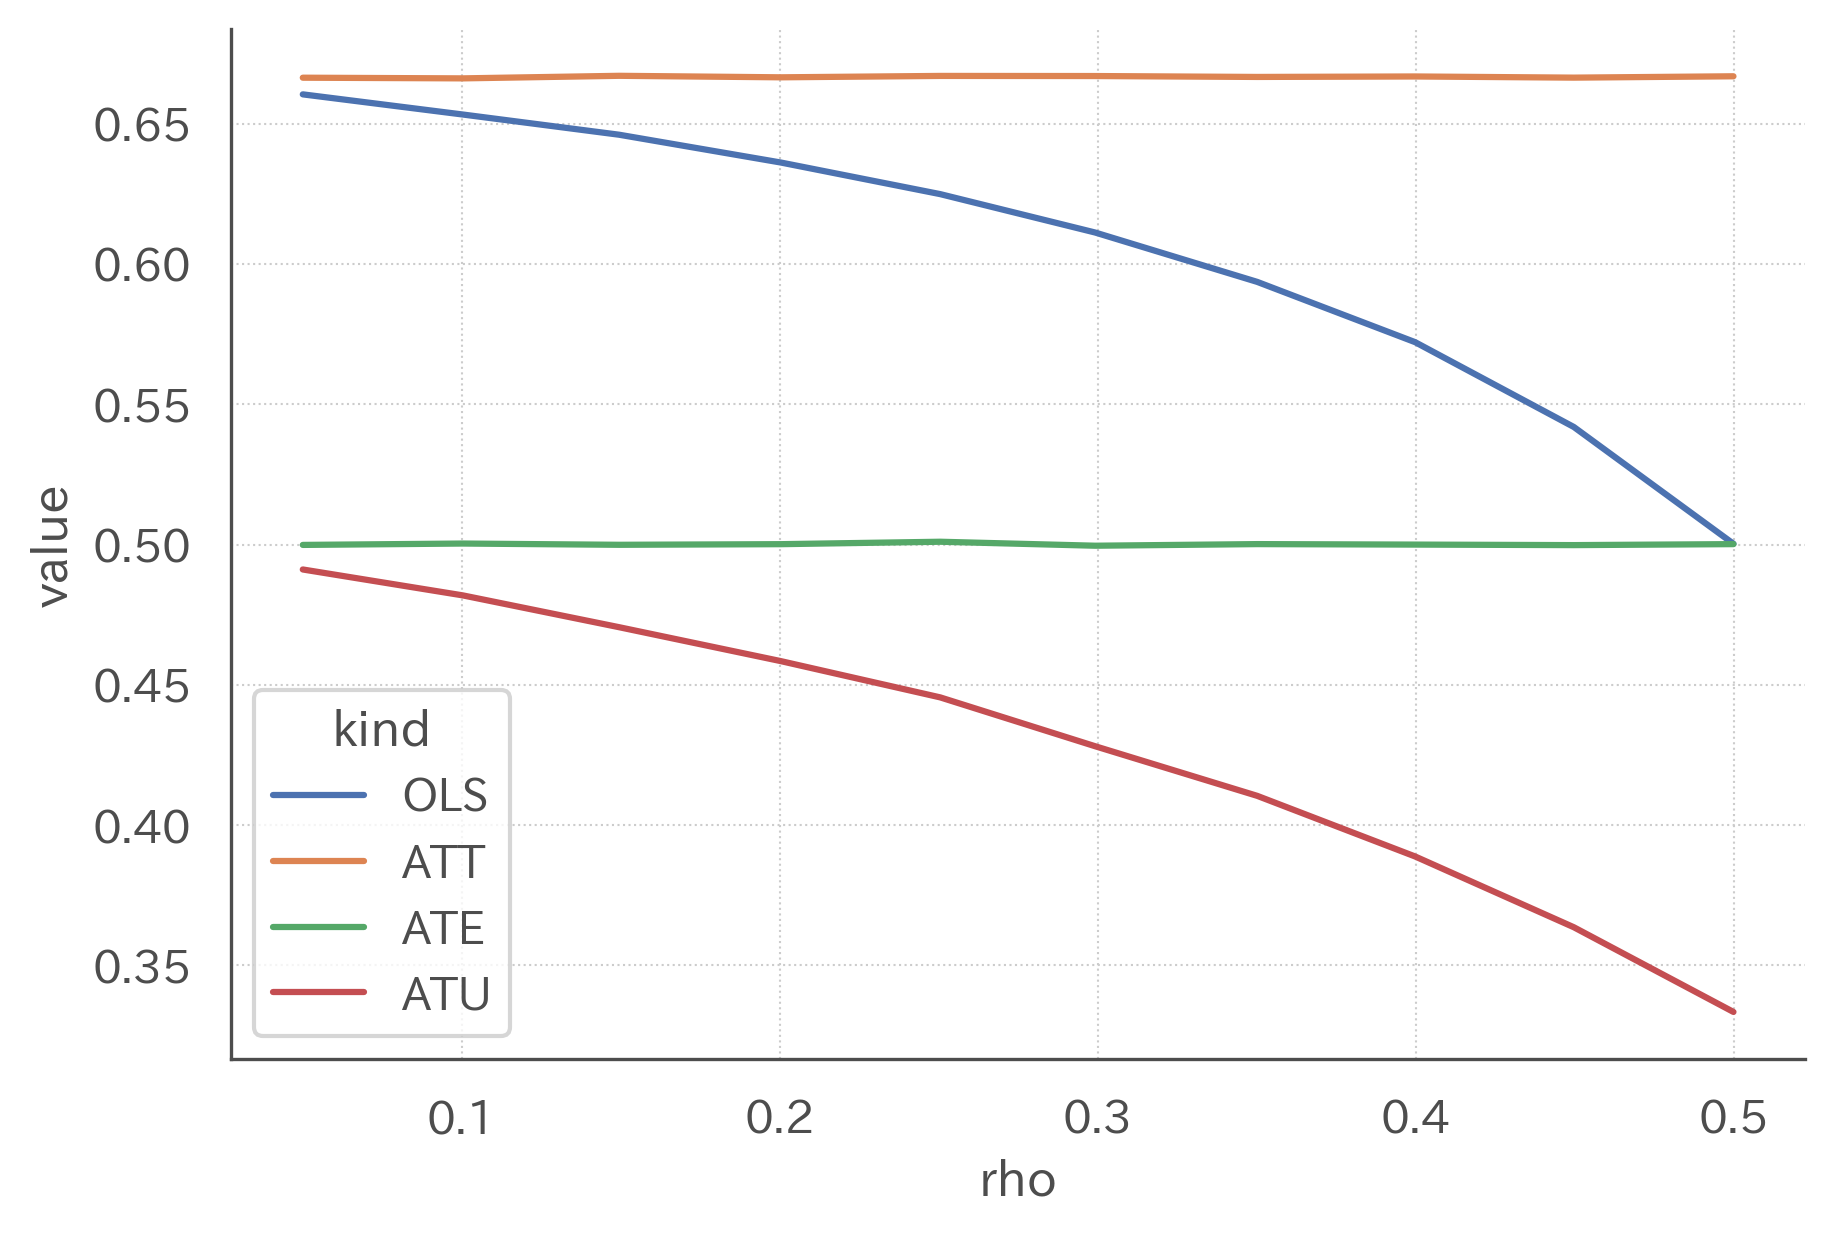

In [163]:
df_long = df_simulation.melt(
    id_vars=["theta", "rho", "w"],
    value_vars=["OLS", "ATT", "ATE", "ATU"],
    var_name="kind",
)

fig, ax = plt.subplots()
sns.lineplot("rho", "value", hue="kind", data=df_long, ax=ax)
fig.show()

$$
\begin{align}
\tau_{\ate} &= \E{\tau(X)} = \E{X} = \frac{1}{2}
\end{align}
$$


$$
\begin{align}
\tau_{\att} &= \E{\tau(X) \mid D = 1} \\
&= \int \tau(x) p(x \mid D=1) dx\\
&= \int \tau(x)\frac{\P{D = 1 \mid X = x}p(x) }{\P{D=1}}dx
\end{align}
$$

$$
\begin{align}
\tau(x) &= x,\\
\P{D = 1 \mid X = x} &= \theta x,\\
p(x) &= 1, \\
\P{D=1} 
&= \E{\P{D = 1 \mid X = x}}, \\
&= \E{\theta X} \\
&= \theta \E{X} \\
&= \frac{1}{2}\theta
\end{align}
$$
なので、
$$
\begin{align}
\tau_{\att} 
&= \int_0^1 x\frac{\theta x }{\theta / 2}dx\\
&= 2\int_0^1 x^2dx\\
&= \frac{2}{3}
\end{align}
$$

$$
\begin{align}
\P{D = 0 \mid X = x} &= 1 - \theta x\\
\P{D=1} &= 1 - \frac{1}{2}\theta
\end{align}
$$

$$
\begin{align}
\tau_{\atu} &= \E{\tau(X) \mid D = 0} \\
&= \int \tau(x) p(x \mid D=1) dx\\
&= \int \tau(x)\frac{\P{D = 0 \mid X = x}p(x) }{\P{D=0}}dx\\
& = \int_0^1 x\frac{1 - \theta x }{1 - \theta / 2}dx\\
&= \frac{2- 3\theta}{3(2 - \theta)}
\end{align}
$$

$$
\begin{align}
\var{e(X) \mid D = 1}
&=\E{e(X)^2 \mid D = 1} - \E{e(X) \mid D = 1}^2
\end{align}
$$

ここで、
$$
\begin{align}
\E{e(X) \mid D = 1} &= \int e(x)p(x \mid D = 1) = 2\theta\int_0^1 x^2 dx = \frac{2}{3}\theta,\\
\E{e(X)^2 \mid D = 1} &= \int e(x)^2p(x \mid D = 1) = 2\theta^2\int_0^1 x^3 dx = \frac{1}{2}\theta^2
\end{align}
$$
であることを利用すると
$$
\begin{align}
\var{e(X) \mid D = 1}
&= \paren{\frac{1}{2}\theta^2} - \paren{\frac{2}{3}\theta}^2\\
&= \frac{1}{18}\theta^2
\end{align}
$$


$$
\begin{align}
\var{e(X) \mid D = 0}
&=\E{e(X)^2 \mid D = 0} - \E{e(X) \mid D = 0}^2
\end{align}
$$
ここで、
$$
\begin{align}
\E{e(X) \mid D = 0} &= \int e(x)p(x \mid D = 0) = \frac{2\theta}{2 - \theta}\int_0^1 \paren{x - \theta x^2} dx = \frac{\theta(3 - 2\theta)}{3(2 - \theta)},\\
\E{e(X)^2 \mid D = 0} &= \int e(x)^2p(x \mid D = 0) = \frac{2\theta^2}{2 - \theta}\int_0^1  \paren{x^2 - \theta x^3} dx = \frac{\theta^2(4 - 3\theta)}{6(2-\theta)}
\end{align}
$$
であることを考慮すると
$$
\begin{align}
\var{e(X) \mid D = 0}
&= \paren{\frac{\theta^2(4 - 3\theta)}{6(2-\theta)}} - \paren{\frac{\theta(3 - 2\theta)}{3(2 - \theta)}}^2\\
&= \frac{\theta^2\paren{\theta^2 - 6\theta + 6}}{18 \paren{2 - \theta}^2}
\end{align}
$$



In [169]:
def calc_theoretical_value(theta: np.ndarray) -> pd.DataFrame:

    ate = 0.5
    att = 2 / 3
    atu = (3 - 2 * theta) / (3 * (2 - theta))
    rho = 0.5 * theta

    var_e_0 = theta ** 2 * (theta ** 2 - 6 * theta + 6) / 18 / (2 - theta) ** 2
    var_e_1 = theta ** 2 / 18
    w = (1 - rho) * var_e_0 / ((1 - rho) * var_e_0 + rho * var_e_1)
    ols = w * att + (1 - w) * atu

    df = pd.DataFrame(
        {
            "theta": theta,
            "rho": rho,
            "w": w,
            "OLS": ols,
            "ATT": att,
            "ATU": atu,
            "ATE": ate,
        }
    )
    return df


df_theory = calc_theoretical_value(theta=np.arange(0.1, 1.05, 0.1))
df_theory

,theta,rho,w,OLS,ATT,ATU,ATE
0,0.1,0.05,0.966071,0.660714,0.666667,0.491228,0.5
1,0.2,0.10,0.930769,0.653846,0.666667,0.481481,0.5
2,0.3,0.15,0.893750,0.645833,0.666667,0.470588,0.5
3,0.4,0.20,0.854545,0.636364,0.666667,0.458333,0.5
4,0.5,0.25,0.812500,0.625000,0.666667,0.444444,0.5
5,0.6,0.30,0.766667,0.611111,0.666667,0.428571,0.5
6,0.7,0.35,0.715625,0.593750,0.666667,0.410256,0.5
7,0.8,0.40,0.657143,0.571429,0.666667,0.388889,0.5
8,0.9,0.45,0.587500,0.541667,0.666667,0.363636,0.5
9,1.0,0.50,0.500000,0.500000,0.666667,0.333333,0.5


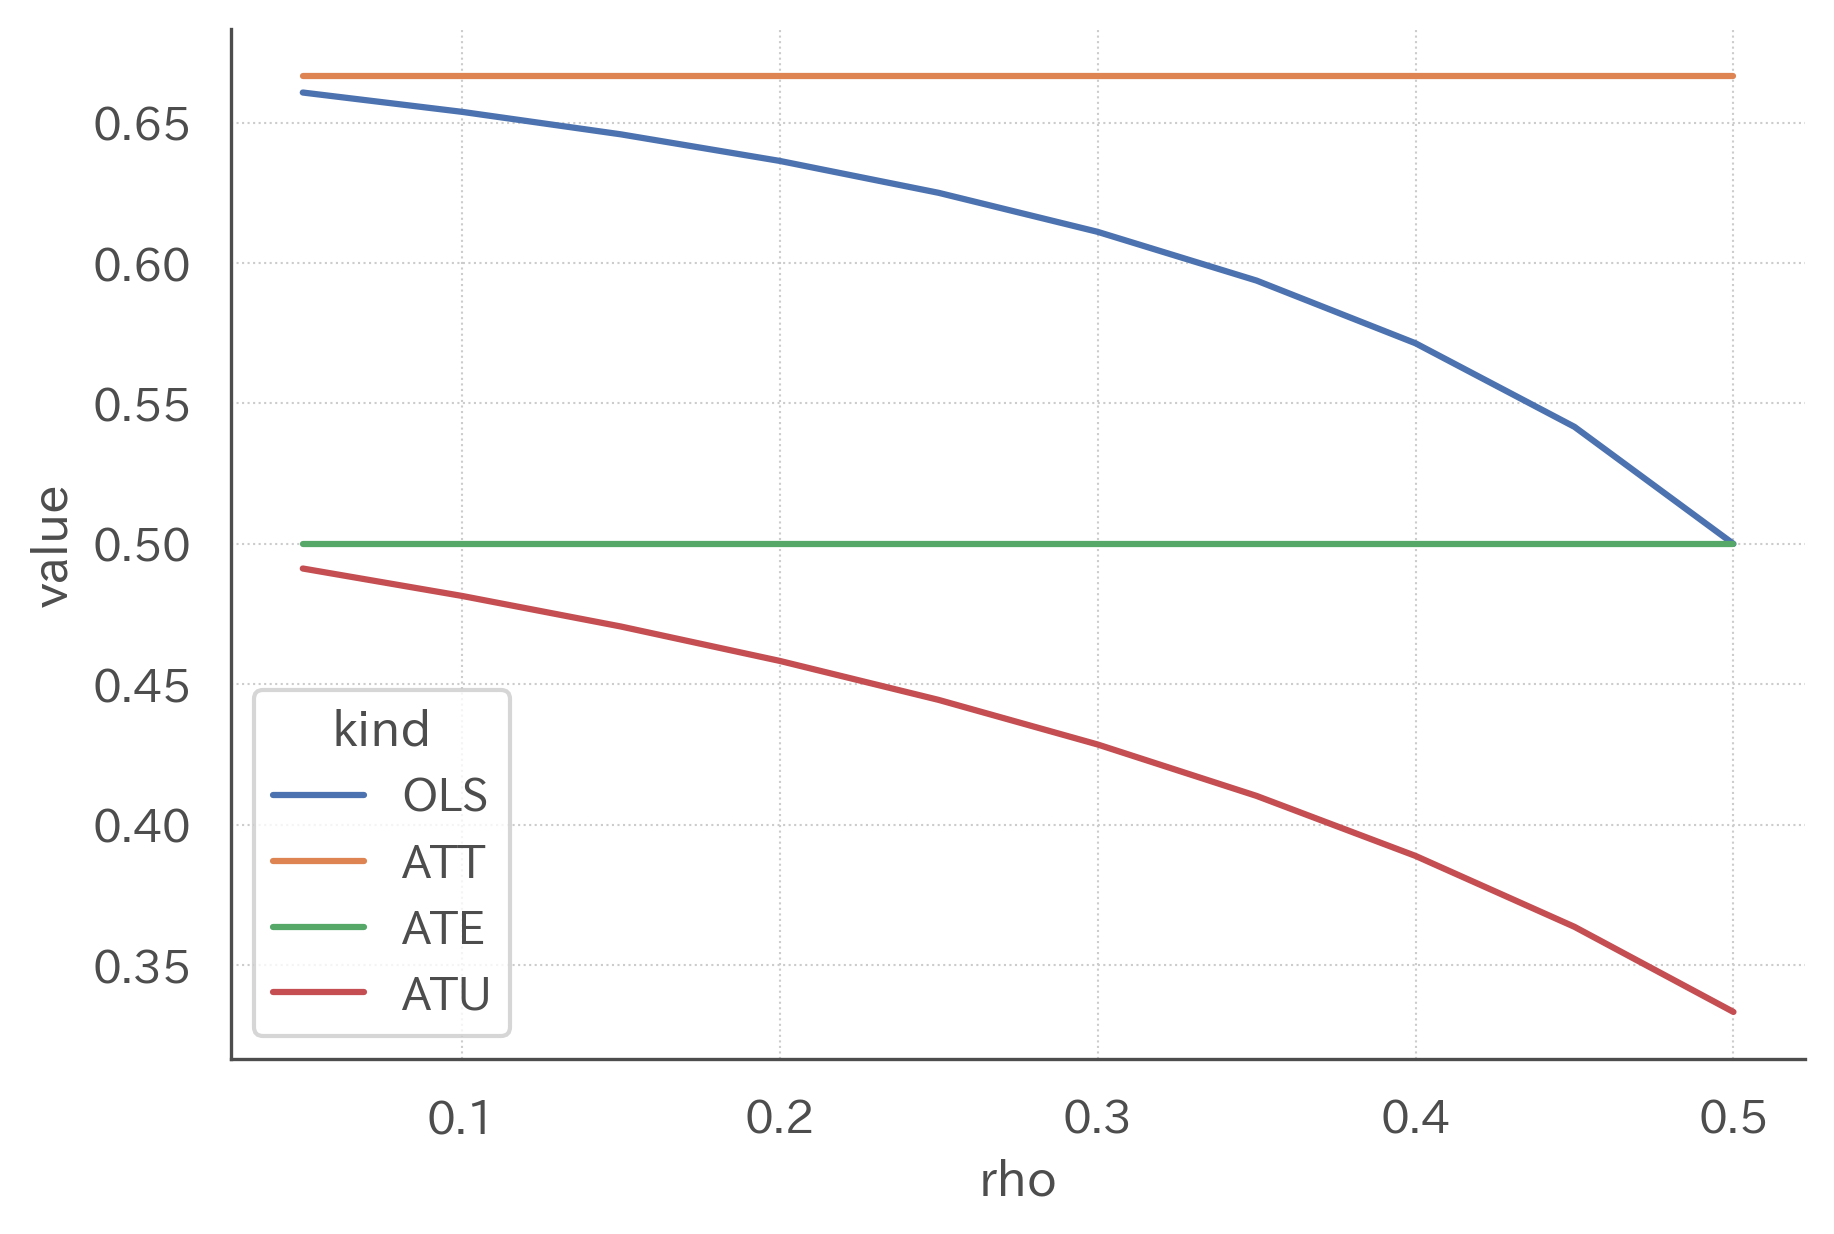

In [170]:
df_long = df_theory.melt(
    id_vars=["theta", "rho", "w"],
    value_vars=["OLS", "ATT", "ATE", "ATU"],
    var_name="kind",
)

fig, ax = plt.subplots()
sns.lineplot("rho", "value", hue="kind", data=df_long, ax=ax)
fig.show()